In [20]:
import re
import ast
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report

tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

In [21]:

inference_logs = load_from_disk("data/combined_dataset")
list(inference_logs.keys())

['BOSS_Sentiment_ID_BERT_Insert',
 'BOSS_Sentiment_ID_BERT_Paraphrase',
 'BOSS_Sentiment_ID_BERT_ICR',
 'BOSS_Sentiment_ID_T5_Insert',
 'BOSS_Sentiment_ID_T5_Substitute',
 'BOSS_Sentiment_ID_T5_Translate',
 'BOSS_Sentiment_ID_T5_Paraphrase',
 'BOSS_Sentiment_ID_T5_ICR',
 'BOSS_Sentiment_ID_Falcon_Insert',
 'BOSS_Sentiment_ID_Falcon_Substitute',
 'BOSS_Sentiment_ID_Falcon_Translate',
 'BOSS_Sentiment_SST5_BERT_Insert',
 'BOSS_Sentiment_SST5_BERT_Substitute',
 'BOSS_Sentiment_SST5_BERT_Translate',
 'BOSS_Sentiment_SST5_BERT_Paraphrase',
 'BOSS_Sentiment_SST5_BERT_ICR',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Insert',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Substitute',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Transla

## Analyze Main Results

In [22]:
main_results_bert_splits = [split for split in inference_logs.keys() if "Ablate" not in split]
datasets = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
split_data = {}

for task_name in datasets:
    if task_name not in split_data:
        split_data[task_name] = {}

    for split in tqdm(main_results_bert_splits):
        if task_name in split:
            distribution = split.split("_")[-3]
            model = split.split("_")[-2]
            tta_method = split.split("_")[-1]
            baseline_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["tta_predicted_class"], output_dict=True)["accuracy"]
            accuracy_delta = tta_accuracy - baseline_accuracy

            if model not in split_data[task_name]:
                split_data[task_name][model] = {}

            if tta_method not in split_data[task_name][model]:
                split_data[task_name][model][tta_method] = {}

            split_data[task_name][model][tta_method][distribution] = {
                "distribution": distribution,
                "model": model,
                "tta_method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "accuracy_delta": accuracy_delta
            }

    # get the mean accuracy delta for each method excluding ID
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            accuracy_deltas = []
            baseline_accuracies = []
            for distribution in split_data[task_name][model_name][tta_method]:
                if distribution == "ID":
                    continue

                current_tta_result = split_data[task_name][model_name][tta_method][distribution]
                accuracy_deltas.append(current_tta_result["accuracy_delta"])
                baseline_accuracies.append(current_tta_result["baseline_accuracy"])

            split_data[task_name][model_name][tta_method]["mean_accuracy_delta"] = np.mean(accuracy_deltas)
            split_data[task_name][model_name][tta_method]["mean_baseline_accuracy"] = np.mean(baseline_accuracies)

print(json.dumps(split_data, indent=4))

  1%|          | 1/130 [00:00<00:26,  4.80it/s]/home/kyobrien/conda/envs/icdt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kyobrien/conda/envs/icdt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kyobrien/conda/envs/icdt/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_s

{
    "BOSS_Sentiment": {
        "BERT": {
            "Insert": {
                "ID": {
                    "distribution": "ID",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.9037888134896155,
                    "tta_accuracy": 0.9047912811022003,
                    "accuracy_delta": 0.001002467612584823
                },
                "SST5": {
                    "distribution": "SST5",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.6847014925373134,
                    "tta_accuracy": 0.683768656716418,
                    "accuracy_delta": -0.0009328358208954279
                },
                "SemEval": {
                    "distribution": "SemEval",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.4497187742435997,
                    "tta_


/home/kyobrien/conda/envs/icdt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kyobrien/conda/envs/icdt/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
# create dataframe where there is a column for dataset, model, id_accuracy_delta, and mean_accuracy_delta
records = []

for task_name in tqdm(split_data):
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            current_tta_result = split_data[task_name][model_name][tta_method]
            records.append({
                "dataset": task_name,
                "model": model_name,
                "tta_method": tta_method,
                "id_accuracy_delta": current_tta_result["ID"]["accuracy_delta"] * 100 if "ID" in current_tta_result else None,
                "ood_mean_accuracy_delta": current_tta_result["mean_accuracy_delta"] * 100,
                "ood_mean_baseline_accuracy": current_tta_result["mean_baseline_accuracy"] * 100,
            })


main_results_frame = pd.DataFrame(records)
for model in split_data[task_name]:
    display(model)
    display(main_results_frame[main_results_frame["model"] == model].drop(columns="model").groupby(["dataset", "tta_method"]).mean().T)


100%|██████████| 3/3 [00:00<00:00, 20627.72it/s]


'BERT'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -1.842105  -0.052632  -1.644737  -0.052632   
ood_mean_accuracy_delta        1.184211   0.276316   0.539474   0.289474   
ood_mean_baseline_accuracy    88.565789  88.565789  88.565789  88.565789   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -1.302632       0.472959   0.100247   0.156796   
ood_mean_accuracy_delta      0.250000       4.860502  -0.127494   2.604881   
ood_mean_baseline_accuracy  88.565789      52.050120  52.050120  52.050120   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta                 NaN        NaN      2.984998        NaN   
ood_mean_accuracy_delta     -0.269537   0.548153      5.160463  -0.807051   
ood_mean_baseline_accuracy  52.050120  52.050120     53.907864  53.907864   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta                 NaN        NaN        NaN  
ood_mean_accuracy_delta      8.744820  -0.538489   7.364210  
ood_mean_baseline_accuracy  53.907864  53.907864  53.907864

'T5'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -2.105263  -2.223684  -1.802632  -2.539474   
ood_mean_accuracy_delta        1.671053   0.552632   1.039474   0.157895   
ood_mean_baseline_accuracy    89.013158  89.013158  89.013158  89.013158   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -2.000000       0.665741  -1.493420  -0.215916   
ood_mean_accuracy_delta      0.078947       1.526458  -0.935397   1.050723   
ood_mean_baseline_accuracy  89.013158      57.988354  57.988354  57.988354   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -3.493214  -2.827473           NaN        NaN   
ood_mean_accuracy_delta     -1.357938  -0.966479      4.749906  -1.634958   
ood_mean_baseline_accuracy  57.988354  57.988354     58.815736  58.815736   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta                 NaN        NaN        NaN  
ood_mean_accuracy_delta      8.025777  -1.291502   3.749890  
ood_mean_baseline_accuracy  58.815736  58.815736  58.815736

'Falcon'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -1.157895  -3.500000  -1.473684  -3.776316   
ood_mean_accuracy_delta             NaN  -1.039474   1.460526  -1.092105   
ood_mean_baseline_accuracy          NaN  25.960526  25.960526  25.960526   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta            0.026316            NaN  -0.611762        NaN   
ood_mean_accuracy_delta     -0.039474      -2.554706  -0.794764  -1.371086   
ood_mean_baseline_accuracy  25.960526      47.166769  47.166769  47.166769   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -2.143738  -2.855747           NaN  -0.065762   
ood_mean_accuracy_delta     -2.220789  -1.897198     -1.009441  -0.812883   
ood_mean_baseline_accuracy  47.166769  47.166769     66.677123  58.835338   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta                 NaN        NaN        NaN  
ood_mean_accuracy_delta     -0.243747   0.805834   0.538183  
ood_mean_baseline_accuracy  66.677123  58.835338  58.835338

# Analyze Across Dataset Sizes

In [24]:
all_splits = [split for split in inference_logs.keys() if "Ablate_Data" in split]
datasets = set([("_".join(split.split("_")[:2]).replace("_Ablate", "")) for split in all_splits if "Ablate_Data" in split])
results = {}
# print(datasets)

for task_name in datasets:
    results[task_name] = {}

    for split_name in tqdm(all_splits, desc=task_name):
        if task_name in split_name:
            data_count = int(split_name.split("_")[-2].replace("BERT", ""))
            tta_method = split_name.split("_")[-1]
            shift_name = split_name.split("_")[-3]
            # print(dataset, data_count, tta_method, shift_name)

            baseline_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["tta_predicted_class"], output_dict=True)["accuracy"]

            if task_name not in results:
                results[task_name] = {}
            if data_count not in results[task_name]:
                results[task_name][data_count] = {}
            if tta_method not in results[task_name][data_count]:
                results[task_name][data_count][tta_method] = {}
            if shift_name not in results[task_name][data_count][tta_method]:
                results[task_name][data_count][tta_method][shift_name] = {}

            results[task_name][data_count][tta_method][shift_name] = {
                "method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "baseline_delta": tta_accuracy - baseline_accuracy,
            }

            # inference_frames[task_name] = inference_logs[split].to_pandas()
            # break

print(json.dumps(results, indent=4))

BOSS_Sentiment: 100%|██████████| 175/175 [00:02<00:00, 65.71it/s]

{
    "BOSS_Toxicity": {
        "3000": {
            "Insert": {
                "Toxigen": {
                    "method": "Insert",
                    "baseline_accuracy": 0.6207627118644068,
                    "tta_accuracy": 0.6101694915254238,
                    "baseline_delta": -0.010593220338983023
                },
                "ImplicitHate": {
                    "method": "Insert",
                    "baseline_accuracy": 0.6128491620111732,
                    "tta_accuracy": 0.6135009310986964,
                    "baseline_delta": 0.0006517690875231796
                },
                "AdvCivil": {
                    "method": "Insert",
                    "baseline_accuracy": 0.36650485436893204,
                    "tta_accuracy": 0.37014563106796117,
                    "baseline_delta": 0.0036407766990291246
                }
            },
            "Substitute": {
                "Toxigen": {
                    "method": "Substitute",
               

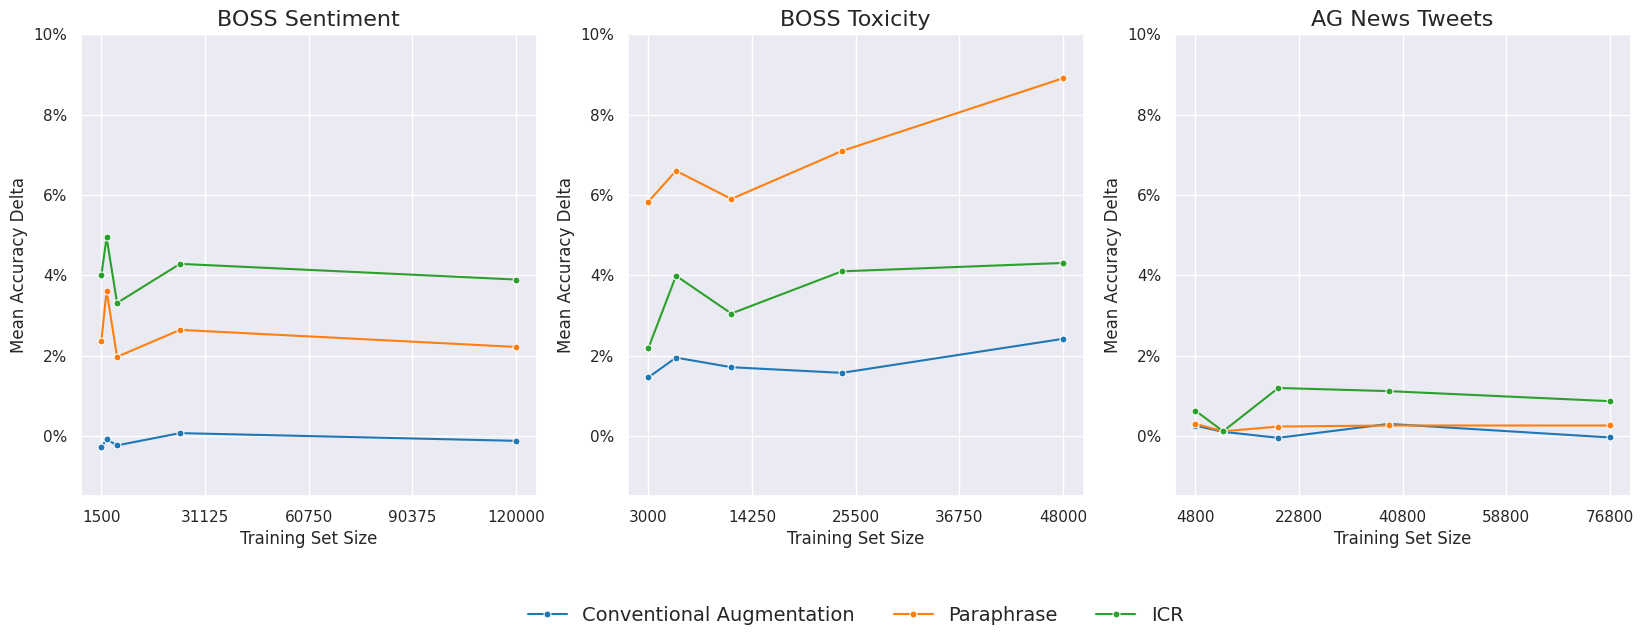

In [25]:
method_avg_delta = {}
for task_name in results:
    for data_count in results[task_name]:
        tta_perf_deltas = {}
        for tta_method in results[task_name][data_count]:
            for ood_shift in results[task_name][data_count][tta_method]:
                if tta_method not in tta_perf_deltas:
                    tta_perf_deltas[tta_method] = []

                shift_method_perf_deta = results[task_name][data_count][tta_method][ood_shift]["baseline_delta"]
                tta_perf_deltas[tta_method].append(shift_method_perf_deta)

        if task_name not in method_avg_delta:
            method_avg_delta[task_name] = {}

        method_avg_delta[task_name][data_count] = { tta_method: np.mean(tta_perf_deltas[tta_method]) for tta_method in tta_perf_deltas }
        baseline = np.mean([method_avg_delta[task_name][data_count]["Insert"], method_avg_delta[task_name][data_count]["Substitute"], method_avg_delta[task_name][data_count]["Translate"]])
        method_avg_delta[task_name][data_count]["Conventional Augmentation"] = baseline

# display(method_avg_delta)

pandas_form = {task_name: {} for task_name in results}
for task_name in pandas_form:
    for data_count in method_avg_delta[task_name]:
        for tta_method in ["Conventional Augmentation", "Paraphrase", "ICR"]:
            if data_count not in pandas_form[task_name]:
                pandas_form[task_name][data_count] = []

            pandas_form[task_name][data_count].append({
                "data_count": data_count,
                "tta_method": tta_method,
                "avg_delta": method_avg_delta[task_name][data_count][tta_method],
            })


fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, task_name in enumerate(["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]):
    df = pd.concat([pd.DataFrame(pandas_form[task_name][data_count]) for data_count in pandas_form[task_name]])
    sns.lineplot(data=df, x="data_count", y="avg_delta", hue="tta_method", ax=axes[i], marker="o", markersize=5)

    # set x label to Training Set Size
    axes[i].set_xlabel("Training Set Size")

    # lgo the x axis
    # axes[i].set_xscale("log")
    # axes[i].set_xticks(df["data_count"].sort_values().unique().tolist())

    # create five equally spaced ticks between the min and max of the x axis
    axes[i].set_xticks(np.linspace(df["data_count"].min(), df["data_count"].max(), 5))

    # set y label to Mean Absolute Accuracy Delta
    axes[i].set_ylabel("Mean Accuracy Delta")

    # make the y axis percents that go to the hundreds place
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize the y axis
    axes[i].set_ylim(-0.015, 0.1)

    title_text = {
        "BOSS_Sentiment": "BOSS Sentiment",
        "BOSS_Toxicity": "BOSS Toxicity",
        "AgNewsTweets": "AG News Tweets",
    }

    axes[i].set_title(title_text[task_name], fontsize=16)

    # se legend to the bottom left
    axes[i].legend(loc="lower right")

    # remove leegnd in not middle plot
    if i != 1:
        axes[i].get_legend().remove()
    else:
        # center below plot with no frame
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)

# add padding
# plt.tight_layout(pad=0.5)
fig.savefig("../datasets/analysis/figures/method_analysis_data_ablation.png", bbox_inches="tight")

# OOD Analysis

In [26]:
sst5_data = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas()
display(sst5_data.head(1))
display(sst5_data.shape)

toxigen_data = inference_logs["BOSS_Toxicity_Toxigen_BERT_ICR"].to_pandas()
display(toxigen_data.head(1))
display(toxigen_data.shape)

agt_data = inference_logs["AgNewsTweets_Tweets_BERT_ICR"].to_pandas()
display(agt_data.head(1))
display(agt_data.shape)

,outcome,original_text,augmentations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,New Mistake,Too much of this well-acted but dangerously sl...,"[The movie, while well-acted, moves at a slow ...",0,2,0,5.271043,0.683401,0.43959,True,0.243811,"[0.14294175803661346, 0.004732172004878521, 0....","[[0.017056187614798546, 0.008808359503746033, ...","[0.13664869964122772, 0.35321399569511414, 0.1..."


(1072, 14)

,outcome,original_text,augmentations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,Unfixed Mistake,While some members of congress take principle...,[While some members of Congress maintain stron...,0,0,1,7.593405,0.000069,0.000071,False,-0.000003,"[0.9999945163726807, 5.425524250313174e-06]","[[0.9999943971633911, 5.5463469834649e-06], [0...","[7.27267688489519e-05, 6.922199827386066e-05, ..."


(944, 14)

,outcome,original_text,augmentations,original_predicted_class,tta_predicted_class,label,tta_inference_latency,original_prediction_entropy,tta_prediction_entropy,prediction_entropy_decreased,prediction_entropy_decrease,tta_mean_class_probs,tta_all_class_probs,tta_all_class_entropy
0,Unchanged Correct,"""Just in: Afghanistan suspends vote counting &...","[Paraphrased Text Paraphrased Text, Afghanist...",0,0,0,1.054248,0.000425,0.00224,False,-0.001815,"[0.9997696280479431, 9.805664376472123e-06, 9....","[[1.7900789316627197e-05, 1.1557237939996412e-...","[0.00027927980409003794, 0.0001130134478444233..."


(7600, 14)

## Does TTA Effect Some Classes More Than Others?

In [27]:
sst5_data.value_counts(["label", "outcome"]).sort_index()

label  outcome          
0      NA                    10
       New Correct           29
       New Mistake            9
       Unchanged Correct    166
       Unfixed Mistake       68
1      NA                     1
       New Correct           24
       New Mistake            9
       Unchanged Correct    339
       Unfixed Mistake       27
2      NA                     9
       New Correct           46
       New Mistake           22
       Unchanged Correct    189
       Unfixed Mistake      124
Name: count, dtype: int64

In [28]:
# get the overall ratio of New Corrections to New Mistakes for sst5_data, toxigen_data, and agt_data
pd.concat([sst5_data, toxigen_data, agt_data]).value_counts(["outcome"]).sort_index()

outcome          
NA                     42
New Correct           289
New Mistake           151
Unchanged Correct    7944
Unfixed Mistake      1190
Name: count, dtype: int64

In [29]:
# for each dataset, get the percent of examples that are unchanged vs new
sst5_outcomes = sst5_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * sst5_outcomes[sst5_outcomes.index == "New Correct"].values[0] + sst5_outcomes[sst5_outcomes.index == "New Mistake"].values[0]
print(f"SST-5: {new_predcitions_percent:.2f}% of examples are new predictions")

toxicgen_outcomes = toxigen_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * toxicgen_outcomes[toxicgen_outcomes.index == "New Correct"].values[0] + toxicgen_outcomes[toxicgen_outcomes.index == "New Mistake"].values[0]
print(f"ToxicGen: {new_predcitions_percent:.2f}% of examples are new predictions")

agt_outcomes = agt_data["outcome"].value_counts(normalize=True)
new_predcitions_percent = 100 * agt_outcomes[agt_outcomes.index == "New Correct"].values[0] + agt_outcomes[agt_outcomes.index == "New Mistake"].values[0]
print(f"AGT: {new_predcitions_percent:.2f}% of examples are new predictions")

SST-5: 9.27% of examples are new predictions
ToxicGen: 4.29% of examples are new predictions
AGT: 1.98% of examples are new predictions


/tmp/ipykernel_3960670/972366342.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst5_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
/tmp/ipykernel_3960670/972366342.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst5_corruptions_corrections["label"] = sst5_corruptions_corrections["label"].apply(lambda l: sst5_labels[l])
/tmp/ipykernel_3960670/972366342.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<Figure size 640x480 with 0 Axes>

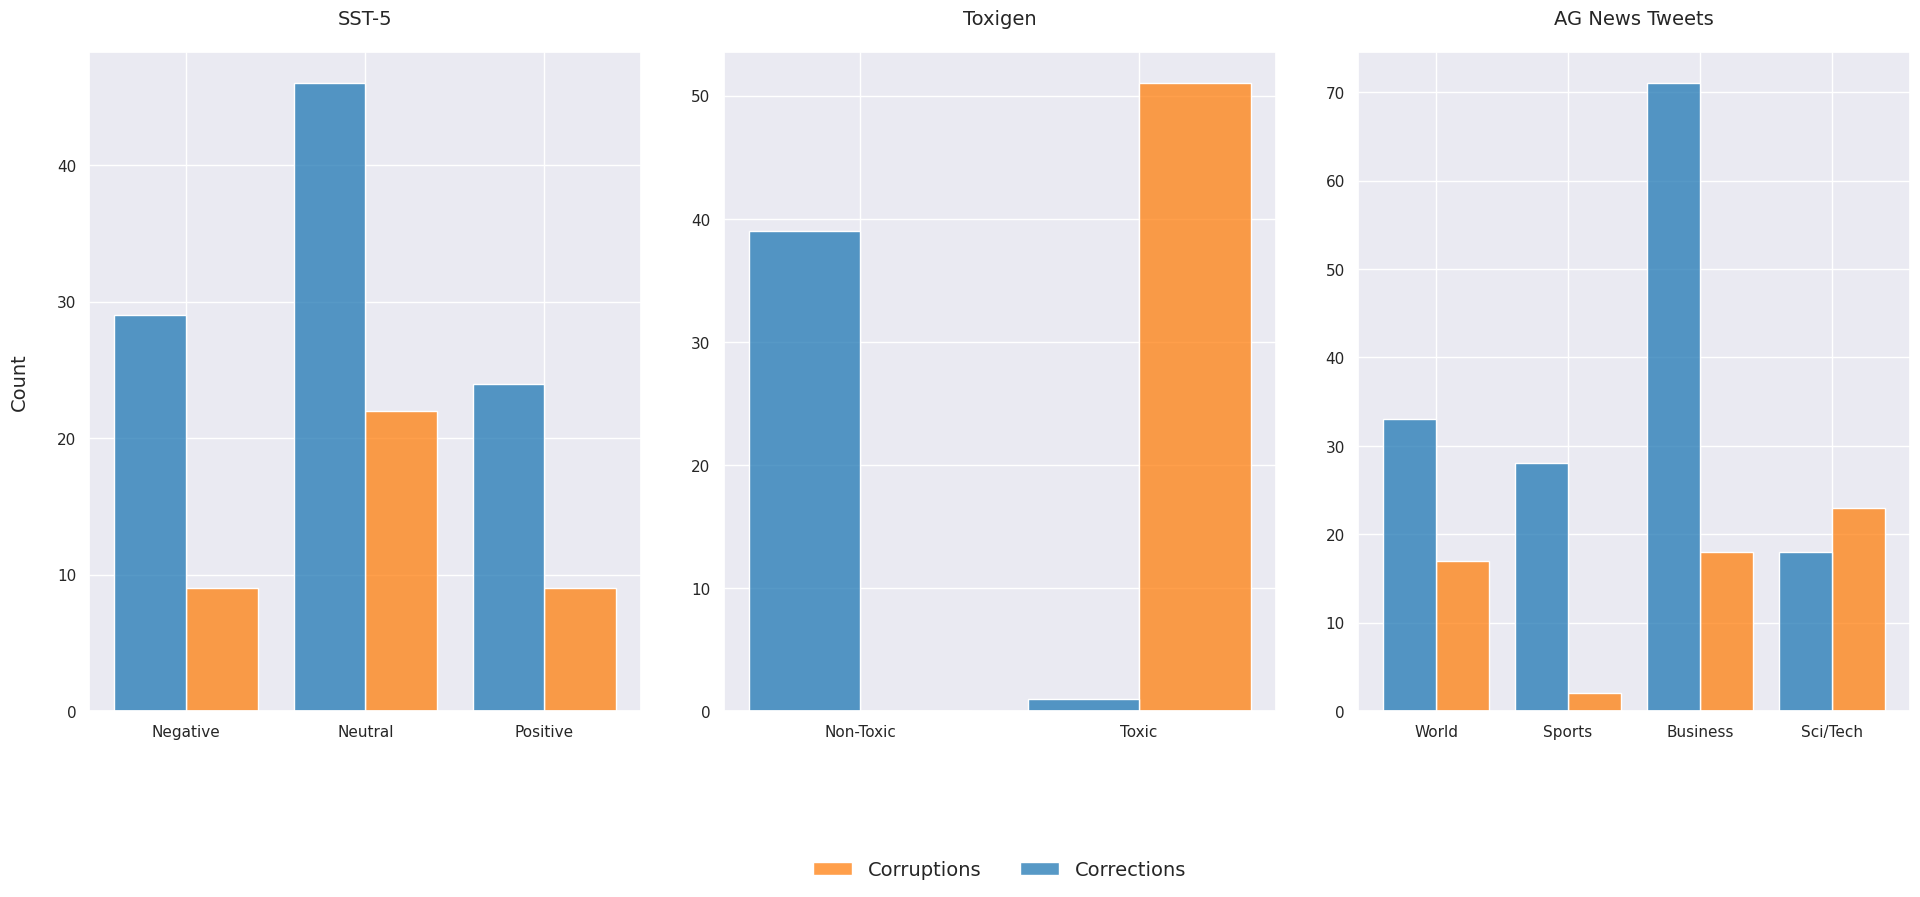

In [30]:
# clear plots
plt.clf()

# Create three histograms on one row
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sst5_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sst5_corruptions_corrections = sst5_data[(sst5_data["outcome"] == "New Correct") | (sst5_data["outcome"] == "New Mistake")]
sst5_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
sst5_corruptions_corrections["label"] = sst5_corruptions_corrections["label"].apply(lambda l: sst5_labels[l])
# sort values by Negative, Neutral, Positive in that order
sst5_corruptions_corrections.sort_values(by=["label"], inplace=True, key=lambda x: x.map({"Negative": 0, "Neutral": 1, "Positive": 2}))
sns.histplot(data=sst5_corruptions_corrections, x="label", hue="outcome", multiple="dodge", shrink=.8, ax=axes[0])

toxigen_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
toxigen_corruptions_corrections = toxigen_data[(toxigen_data["outcome"] == "New Correct") | (toxigen_data["outcome"] == "New Mistake")]
toxigen_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
toxigen_corruptions_corrections["label"] = toxigen_corruptions_corrections["label"].apply(lambda l: toxigen_labels[l])
sns.histplot(data=toxigen_corruptions_corrections, x="label", hue="outcome", multiple="dodge", shrink=.8, ax=axes[1])

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
agt_corruptions_corrections = agt_data[(agt_data["outcome"] == "New Correct") | (agt_data["outcome"] == "New Mistake")]
agt_corruptions_corrections.sort_values(by=["label", "outcome"], inplace=True)
agt_corruptions_corrections["label"] = agt_corruptions_corrections["label"].apply(lambda l: agt_labels[l])
sns.histplot(data=agt_corruptions_corrections, x="label", hue="outcome", multiple="dodge", shrink=.8, ax=axes[2])

axes[0].set_ylabel("Count", labelpad=20, fontsize=14)
axes[1].set_ylabel("")
axes[2].set_ylabel("")
axes[0].set_xlabel("SST-5", labelpad=20, fontsize=14)
axes[1].set_xlabel("Toxigen", labelpad=20, fontsize=14)
axes[2].set_xlabel("AG News Tweets", labelpad=20, fontsize=14)

# set x labels above the plots
axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
axes[2].xaxis.set_label_position('top')

# Have a shared legend
axes[0].get_legend().remove()
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), labels=["Corruptions", "Corrections"], ncol=2, fancybox=False, frameon=False, fontsize=14)
axes[2].get_legend().remove()


# add padding
fig.tight_layout(pad=3.0)
fig.savefig("../datasets/analysis/figures/corruptions_corrections_histograms.png", bbox_inches='tight', dpi=300)



In [40]:
inference_logs["BOSS_Sentiment_ID_T5_ICR"]

Dataset({
    features: ['outcome', 'original_text', 'augmentations', 'original_predicted_class', 'tta_predicted_class', 'label', 'tta_inference_latency', 'original_prediction_entropy', 'tta_prediction_entropy', 'prediction_entropy_decreased', 'prediction_entropy_decrease', 'tta_mean_class_probs', 'tta_all_class_probs', 'tta_all_class_entropy'],
    num_rows: 38904
})

## Heatmap Correlations

In [31]:
# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
from scipy.stats import pearsonr as pearson_correlation

# API - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html
from scipy.stats import spearmanr as spearman_correlation

from scipy.stats import pointbiserialr

# Paper - https://arxiv.org/abs/1909.10140
# API - https://swarnakumar.github.io/xicorpy/xi/
# from xicorpy import compute_xi_correlation as xi_correlation

from sklearn import preprocessing

conditional_test_outputs = dict()

outcome_map = {
        "New Correct": 3,
        "New Mistake": 2,
        "Unchanged Correct": 1,
        "Unfixed Mistake": 0,
        "NA": None
    }
reverse_outcome_map = {v: k for k, v in outcome_map.items()}

for split in ["BOSS_Sentiment_ID_BERT_ICR", "BOSS_Sentiment_SST5_BERT_ICR"]:
    correlation_records = []

    for outcome in outcome_map.values():
        if outcome is None:
            continue
        for correlation_metric in ["original_prediction_entropy", "tta_prediction_entropy", "prediction_entropy_decrease"]:
            study_frame = inference_logs[split].to_pandas()
            study_frame["outcome"] = study_frame["outcome"].apply(lambda o: int(outcome_map[o] == outcome))
            study_frame.dropna(inplace=True)
            correlation_results = pointbiserialr(study_frame[correlation_metric], study_frame["outcome"])
            correlation_records.append({
                "outcome": reverse_outcome_map[outcome],
                f"{correlation_metric}_correlation": correlation_results[0],
                f"{correlation_metric}_p-value": correlation_results[1],
            })

    print(f"Split: {split}")
    display(pd.DataFrame(correlation_records).groupby("outcome").mean())


Split: BOSS_Sentiment_ID_BERT_ICR


,original_prediction_entropy_correlation,original_prediction_entropy_p-value,tta_prediction_entropy_correlation,tta_prediction_entropy_p-value,prediction_entropy_decrease_correlation,prediction_entropy_decrease_p-value
outcome,,,,,,
New Correct,0.320918,0.0,0.315037,0.0,0.007230,1.539703e-01
New Mistake,0.208196,0.0,0.294874,0.0,-0.154156,2.285083e-205
Unchanged Correct,-0.516980,0.0,-0.566368,0.0,0.091676,2.425015e-73
Unfixed Mistake,0.313689,0.0,0.326801,0.0,-0.026040,2.812946e-07


Split: BOSS_Sentiment_SST5_BERT_ICR


,original_prediction_entropy_correlation,original_prediction_entropy_p-value,tta_prediction_entropy_correlation,tta_prediction_entropy_p-value,prediction_entropy_decrease_correlation,prediction_entropy_decrease_p-value
outcome,,,,,,
New Correct,0.280441,7.990773e-21,0.328018,2.621155e-28,-0.061719,0.043350
New Mistake,0.212347,2.145339e-12,0.187790,5.771877e-10,0.046493,0.128182
Unchanged Correct,-0.442123,1.600837e-52,-0.540031,3.480700e-82,0.132545,0.000013
Unfixed Mistake,0.173677,1.044427e-08,0.253155,3.880291e-17,-0.115186,0.000157


## Calculate Optimal ID Entropy Thresholds

In [32]:
def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if row["tta_prediction_entropy"] > threshold else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

In [33]:
optimal_entropy_thresholds = {}
thresholds = np.arange(0.1, 1, 0.1)
for split in [dataset for dataset in inference_logs if "ID_BERT_ICR" in dataset]:
    best_threshold = None
    for threshold in tqdm(thresholds):
        accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, inference_logs[split].to_pandas())
        if best_threshold is None or accuracy > best_threshold["accuracy"]:
            best_threshold = {
                "threshold": threshold,
                "accuracy": accuracy,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }

    optimal_entropy_thresholds[split] = best_threshold
    print(f"{split}: {best_threshold}")



  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


BOSS_Sentiment_ID_BERT_ICR: {'threshold': 0.1, 'accuracy': 0.908955377339091, 'llm_call_rate': '0.52%'}


100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


BOSS_Toxicity_ID_BERT_ICR: {'threshold': 0.1, 'accuracy': 0.9032675709001233, 'llm_call_rate': '0.02%'}


100%|██████████| 9/9 [00:00<00:00, 10.83it/s]

AgNewsTweets_ID_BERT_ICR: {'threshold': 0.7000000000000001, 'accuracy': 0.9481578947368421, 'llm_call_rate': '0.00%'}


## Class Based Selective Augmentation

In [38]:
def combined_selective_augment(row, entropy_threshold, responsive_classes):
    if row["original_prediction_entropy"] > entropy_threshold and row["original_predicted_class"] in responsive_classes:
        return row["tta_predicted_class"]
    return row["original_predicted_class"]

    # if row["original_prediction_entropy"] > entropy_threshold:
    #     return row["tta_predicted_class"]
    # if row["original_predicted_class"] in responsive_classes:
    #     return row["tta_predicted_class"]
    # return row["original_predicted_class"]


model = "BERT"
id_icr_logs = [split for split in inference_logs if f"ID_{model}_ICR" in split]
ood_icr_reports = [split for split in inference_logs if f"{model}_ICR" in split and f"ID_{model}_ICR" not in split]
perf_records = []

# display(id_icr_logs)
# display(ood_icr_reports)
for id_icr_split in id_icr_logs:
    # print(f"{id_icr_split}:")
    id_icr_data = inference_logs[id_icr_split].to_pandas()
    change_predictions_count_by_label = id_icr_data[id_icr_data["outcome"].str.contains("New")].value_counts(["label", "outcome"]).sort_index()

    # get list of labels where New Correct > New Mistake
    labels_list = []
    for label in change_predictions_count_by_label.index.levels[0]:
        new_correct_count = change_predictions_count_by_label.loc[label].values[0]
        new_mistake_count = change_predictions_count_by_label.loc[label].values[1]
        if new_correct_count > 1 * new_mistake_count:
            labels_list.append(label)

    # display(change_predictions_count_by_label)
    # display(labels_list)

    perf_records.append({
        "split": id_icr_split,
        "tta": None,
        "accuracy": classification_report(id_icr_data["label"], id_icr_data["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    perf_records.append({
        "split": id_icr_split,
        "tta": "100% AR",
        "accuracy": classification_report(id_icr_data["label"], id_icr_data["tta_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    # print("Only Augment Response Label Report")
    selective_predictions = id_icr_data.apply(lambda row: row["tta_predicted_class"] if row["label"] in labels_list else row["original_predicted_class"], axis=1)
    # print(classification_report(id_icr_data["label"], selective_predictions, digits=4, zero_division=0))
    perf_records.append({
        "split": id_icr_split,
        "tta": "class-based",
        "accuracy": classification_report(id_icr_data["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    # print("Evlauate on OOD Shifts")
    for ood_icr_report in [shift for shift in ood_icr_reports if id_icr_split[:10] in shift]:
        ood_icr_data = inference_logs[ood_icr_report].to_pandas()
        # print(f"{ood_icr_report} TTA Baseline:")
        # print(classification_report(ood_icr_data["label"], ood_icr_data["tta_predicted_class"], digits=4, zero_division=0))
        perf_records.append({
            "split": ood_icr_report,
            "tta": None,
            "accuracy": classification_report(ood_icr_data["label"], ood_icr_data["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
        })

        perf_records.append({
            "split": ood_icr_report,
            "tta": "100% AR",
            "accuracy": classification_report(ood_icr_data["label"], ood_icr_data["tta_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
        })

        # print(f"{ood_icr_report} Selective Augment: Class-based:")
        selective_predictions = ood_icr_data.apply(lambda row: row["tta_predicted_class"] if row["original_predicted_class"] in labels_list else row["original_predicted_class"], axis=1)
        # print(classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0))
        perf_records.append({
            "split": ood_icr_report,
            "tta": "class-based",
            "accuracy": classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
            "augmentation_rate": sum(ood_icr_data["original_predicted_class"].isin(labels_list)) / len(ood_icr_data),
        })

        # print(f"{ood_icr_report} Selective Augment: Entropy-based")
        optimal_entropy_threshold = optimal_entropy_thresholds[id_icr_split]["threshold"]
        accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, ood_icr_data)[0]
        perf_records.append({
            "split": ood_icr_report,
            "tta": "entropy-based",
            "accuracy": accuracy,
            "augmentation_rate": sum(ood_icr_data["original_prediction_entropy"] > optimal_entropy_threshold) / len(ood_icr_data),
        })

        # # print(f"{ood_icr_report} Selective Augment: Class-based & Entropy-based")
        # selective_predictions = ood_icr_data.apply(lambda row: combined_selective_augment(row, optimal_entropy_threshold, labels_list), axis=1)
        # # print(classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0))
        # perf_records.append({
        #     "split": ood_icr_report,
        #     "tta": "class-based or entropy-based",
        #     "accuracy": classification_report(ood_icr_data["label"], selective_predictions, digits=4, zero_division=0, output_dict=True)["accuracy"],
        # })


pd.DataFrame(perf_records).groupby(["split", "tta"]).mean().round(4)

accuracy  augmentation_rate
split                               tta                                       
AgNewsTweets_ID_BERT_ICR            100% AR          0.9299                NaN
                                    class-based      0.9499                NaN
AgNewsTweets_Tweets_BERT_ICR        100% AR          0.8975                NaN
                                    class-based      0.8929             0.5597
                                    entropy-based    0.8861             0.0005
BOSS_Sentiment_Dynasent_BERT_ICR    100% AR          0.4771                NaN
                                    class-based      0.4771             1.0000
                                    entropy-based    0.4771             0.9718
BOSS_Sentiment_ID_BERT_ICR          100% AR          0.9085                NaN
                                    class-based      0.9085                NaN
BOSS_Sentiment_SST5_BERT_ICR        100% AR          0.7397                NaN
                                    class-based      0.7397             1.0000
                                    entropy-based    0.7397             0.8853
BOSS_Sentiment_SemEval_BERT_ICR     100% AR          0.4905                NaN
                                    class-based      0.4905             1.0000
                                    entropy-based    0.4905             0.9652
BOSS_Toxicity_AdvCivil_BERT_ICR     100% AR          0.4600                NaN
                                    class-based      0.4223             0.5862
                                    entropy-based    0.4478             0.0813
BOSS_Toxicity_ID_BERT_ICR           100% AR          0.9145                NaN
                                    class-based      0.9283                NaN
BOSS_Toxicity_ImplicitHate_BERT_ICR 100% AR          0.6564                NaN
                                    class-based      0.6452             0.4938
                                    entropy-based    0.6523             0.0422
BOSS_Toxicity_Toxigen_BERT_ICR      100% AR          0.6557                NaN
                                    class-based      0.6684             0.6504
                                    entropy-based    0.6557             0.0350

# Entropy-Based Selective Augmentation# Entropy Analysis

## Entropy Accuracy Curves

In [29]:
thresholds = np.arange(0, 1, 0.01)
# thresholds = np.arange(0, 1, 0.05)

baseline_perf = {
    "SST-5": 0.6847,
    "Sem Eval": 0.4498,
    "Dynasent": 0.4271,
    "ToxiGen": 0.6670,
    "Adv Civil": 0.3050,
    "Implicit Hate": 0.6454,
    "AG News Tweets": 0.8857,
}

Calculating entropy threshold scores:   0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'get_threshold_accuracy' is not defined

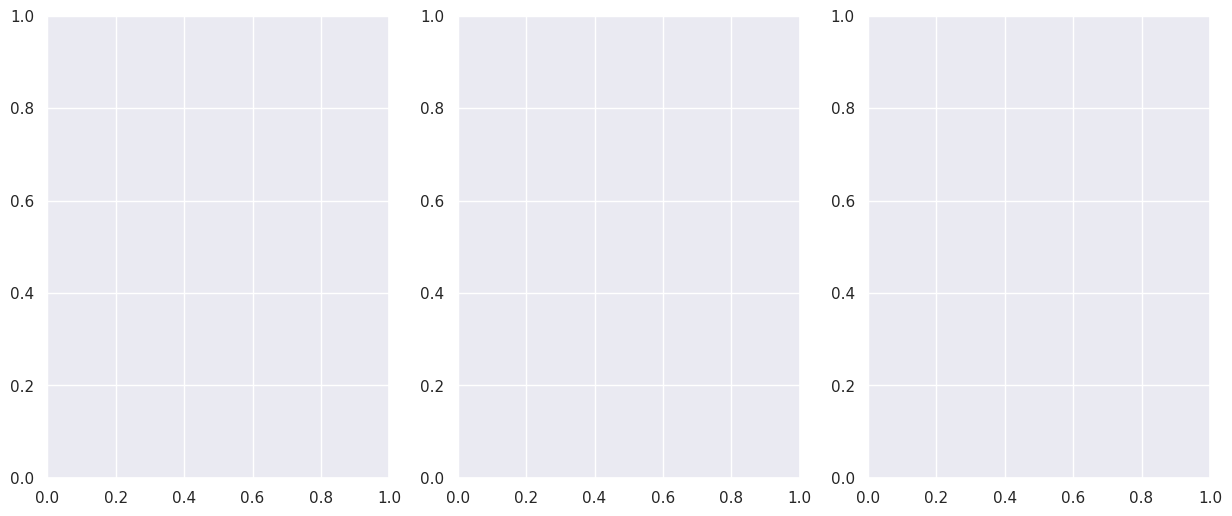

In [30]:
# create a fix where each plot is 5 inches wide and 5 inches tall with 2 padding
fig, axs = plt.subplots(ncols=3, figsize=(15, 6))

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": 0,
        "ToxiGen": 1,
        "AG News Tweets": 2,
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if dataset_name == "ToxiGen" else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if dataset_name == "SST-5" else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    # plot dashed gray line representing the baseline withour augmentation
    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")
    # figure.axhline(baseline_perf[dataset_name], color="gray", linestyle="--", linewidth=1.5, alpha=0.75)
    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    if dataset_name == "ToxiGen":
        figure.legend(loc="upper center", fontsize=12, frameon=False, ncol=3,
                      bbox_to_anchor=(0.5, -0.2),
                      )

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original_predicted_class"] if row["original_prediction_entropy"] < target_threshold["threshold"] else row["tta_predicted_class"], axis=1)
    return original_judgments, rewrite_rate


calculate_entropy_threshold_jugments(inference_logs["BOSS_Sentiment_ID_BERT_ICR"].to_pandas(), "SST-5")
calculate_entropy_threshold_jugments(inference_logs["BOSS_Toxicity_ID_BERT_ICR"].to_pandas(), "ToxiGen")
calculate_entropy_threshold_jugments(inference_logs["AgNewsTweets_ID_BERT_ICR"].to_pandas(), "AG News Tweets")
fig.tight_layout(pad=1.0)
fig.savefig("../datasets/analysis/entropy_figures/main_acc_rewrite_curves.png", bbox_inches="tight")

## Appendix Entropy Figures

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 10), nrows=2)

def calculate_entropy_threshold_jugments(inference_log_frame, dataset_name, half=False):
    # thresholds = np.arange(0, 1, 0.0001)
    threshold_scores = []
    threshold_rewrite_rates = []
    for t in tqdm(thresholds, desc="Calculating entropy threshold scores"):
        t_perf, t_rate = get_threshold_accuracy(t, inference_log_frame)
        threshold_scores.append(t_perf)
        threshold_rewrite_rates.append(t_rate)

    thresholds_frame = pd.DataFrame({"threshold": thresholds, "accuracy": threshold_scores, "rewrite_rate": threshold_rewrite_rates})

    # Set line splot
    coordinates = {
        "SST-5": (0, 0),
        "Sem Eval": (0, 1),
        "Dynasent": (0, 2),
        "ToxiGen": (0, 3),
        "Adv Civil": (1, 0),
        "Implicit Hate": (1, 1),
        "AG News Tweets": (1, 2),
    }

    # Create a line plot with the coordinates in the grid
    figure = axs[coordinates[dataset_name][0]][coordinates[dataset_name][1]]
    figure = sns.lineplot(data=thresholds_frame, x="rewrite_rate", y="accuracy", label="TTA", ax=figure)
    figure.set_title(dataset_name, fontsize=18, pad=15)
    figure.set_xlabel("Augmentation Rate" if dataset_name in ["ToxiGen", "Adv Civil", "Implicit Hate", "AG News Tweets"] else "", labelpad=20, fontsize=14)
    figure.set_ylabel("Accuracy" if dataset_name in ["SST-5", "Adv Civil"] else "", labelpad=20, fontsize=14)
    figure.title.set_size(18)
    figure.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0%}".format(x)))
    figure.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2%}".format(x)))
    figure.set_xlim(left=0)
    figure.lines[0].set_linewidth(2)
    figure.legend_.remove()

    # Display max accuracy point
    accuracy_max_point = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1].to_dict()
    figure.plot(accuracy_max_point["rewrite_rate"],
                accuracy_max_point["accuracy"],
                marker="o",
                markersize=6,
                label="Optimal",
                )
    figure.annotate(f"{accuracy_max_point['accuracy']:.2%}",
                    (accuracy_max_point["rewrite_rate"], accuracy_max_point["accuracy"]),
                    textcoords="offset points",
                    xytext=(10, 0),
                    ha="left",
                    fontsize=10)

    figure.plot([0, 1], [baseline_perf[dataset_name], baseline_perf[dataset_name]], color="gray", linestyle="--", linewidth=1.5, alpha=0.75, label="No TTA (Baseline)")

    if dataset_name == "SST-5":
        figure.set_ylim(bottom=baseline_perf[dataset_name] - 0.005)

    target_threshold = None
    if half is False:
        target_threshold = thresholds_frame[thresholds_frame["accuracy"] == thresholds_frame.max()["accuracy"]].sort_values("rewrite_rate").iloc[-1]
    else:
        thresholds_deltas_list = abs(thresholds_frame["rewrite_rate"] - 50).tolist()
        closest_half_delta = min(thresholds_deltas_list)
        closest_threshold_index = thresholds_deltas_list.index(closest_half_delta)
        target_threshold = thresholds_frame.iloc[closest_threshold_index]

    rewrite_rate = target_threshold["rewrite_rate"] / 100
    original_judgments = inference_log_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < target_threshold["threshold"] else row["judgment"], axis=1)
    return original_judgments, rewrite_rate


def get_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["original judgment"] if row["original entropy"] < threshold else row["judgment"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True)
    llm_call_count = (inference_logs_frame["original entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


calculate_entropy_threshold_jugments(sst5_data, "SST-5")
calculate_entropy_threshold_jugments(semval_data, "Sem Eval")
calculate_entropy_threshold_jugments(dynasent_data, "Dynasent")
calculate_entropy_threshold_jugments(toxigen_data, "ToxiGen")
calculate_entropy_threshold_jugments(adv_civil_data, "Adv Civil")
calculate_entropy_threshold_jugments(implicit_hate_data, "Implicit Hate")
calculate_entropy_threshold_jugments(agt_data, "AG News Tweets")

fig.delaxes(axs[1, -1])
fig.legend(loc="lower center", fontsize=12, frameon=False, ncol=3, labels=["TTA", "No TTA (Baseline)", "Optimal Aug Rate"], bbox_to_anchor=(0.5, -0.025))
fig.tight_layout(pad=2.0)
fig.savefig("../datasets/analysis/entropy_figures/appendix_acc_rewrite_curves.png", bbox_inches="tight")

In [ ]:
sem_eval_original_entropies = semval_data["original entropy"].tolist()
figure = sns.scatterplot(data=semval_data, x=range(len(sem_eval_original_entropies)), y="original entropy", hue="outcome", s=5)
# set legend to the right vertically
figure.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, frameon=False, title="Outcome")
# make y axis log scale
figure.set_yscale("log")

In [ ]:
sst5_data[["original entropy", "outcome"]].groupby("outcome").describe()

In [ ]:
# heatmap between original entropy and outcome
pd.crosstab(sst5_data["original entropy"], semval_data["outcome"])